<a href="https://colab.research.google.com/github/isa-ulisboa/greends-pml/blob/main/Image_Segmentation_with_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adapted from # Lesson 4 - Image Segmentation at https://walkwithfastai.com/Segmentation

# Image segmentation with a Unet

In [3]:
#hide
#Run once per session
!pip install fastai wwf -q --upgrade

In [5]:
!pip install importlib_metadata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
#hide_input
from wwf.utils import state_versions
state_versions(['fastai', 'fastcore', 'wwf'])


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `fastai`, `fastcore`, and `wwf` currently running at the time of writing this:
* `fastai` : 2.7.12 
* `fastcore` : 1.5.29 
* `wwf` : 0.0.16 
---

What is segmentation?

* Pixel-wise classes
* Used for fine-grained image segmenting

![](https://www.researchgate.net/profile/Anna_Boers/publication/235885350/figure/fig2/AS:299772243136518@1448482680597/Example-of-incorrect-automated-segmentation-due-to-hemorrhage-and-erroneous-midline.png)
[URL](https://www.researchgate.net/profile/Anna_Boers/publication/235885350/figure/fig2/AS:299772243136518@1448482680597/Example-of-incorrect-automated-segmentation-due-to-hemorrhage-and-erroneous-midline.png)

![](https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2018/11/26/semantic-segmentation-1.jpg)
[URL](https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2018/11/26/semantic-segmentation-1.jpg)

# Libraries

In [ ]:
from fastai.vision.all import *

Below you will find the exact imports for everything we use today

In [ ]:
from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish
from fastai.losses import BaseLoss
from fastai.optimizer import ranger

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

from PIL import Image
import numpy as np

from torch import nn
from torchvision.models.resnet import resnet34

import torch
import torch.nn.functional as F

## Dataset

Todays dataset will be `CAMVID`, which is a segmentation based problem from cameras on cars to segment various areas of the road

In [ ]:
path = untar_data(URLs.CAMVID)

In [ ]:
# check the folder to see how the examples and labels (masks) are organized
path

Path('/root/.fastai/data/camvid')

Python 3.4 introduced a new standard library for dealing with files and paths called pathlib. To use it, you just pass a path or filename into a new Path() object using forward slashes and it handles the rest. For example, we can read the contents of a text file without having to mess with opening and closing the file. 

Our validation set is inside a text document called `valid.txt` and split by new lines. Let's read it in:

In [ ]:
valid_fnames = (path/'valid.txt').read_text().split('\n')

In [ ]:
valid_fnames[:5]

['0016E5_07959.png',
 '0016E5_07961.png',
 '0016E5_07963.png',
 '0016E5_07965.png',
 '0016E5_07967.png']

Let's look at an image and see how everything aligns up

In [ ]:
# there is one folder for examples and one folder for masks
path_im = path/'images'
path_lbl = path/'labels'

First we need our filenames

In [ ]:
fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)

And now let's work with one of them

<Axes: >

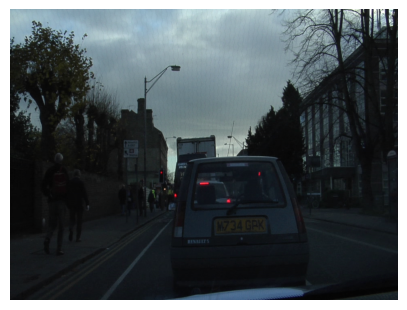

In [ ]:
img_fn = fnames[10]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

Now let's grab our y's. They live in the `labels` folder and are denoted by a `_P`. For `.stem` and `.suffix` see https://medium.com/@ageitgey/python-3-quick-tip-the-easy-way-to-deal-with-file-paths-on-windows-mac-and-linux-11a072b58d5f. Also called “formatted string literals,” f-strings are string literals that have an f at the beginning and curly braces containing expressions that will be replaced with their values. Because f-strings are evaluated at runtime, you can put any and all valid Python expressions in them.

In [ ]:
get_msk = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}'

The stem and suffix grab everything before and after the period respectively.

Our masks are of type `PILMask` and we will make our gradient percentage (alpha) equal to 1 as we are not overlaying this on anything yet

<Axes: >

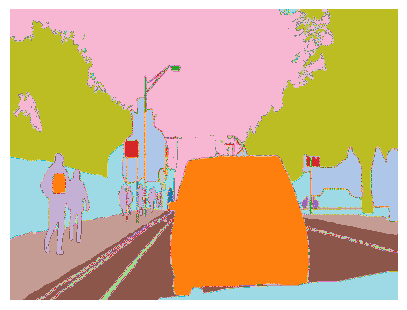

In [ ]:
# get_msk(img_fn) returns the corresponding label (mask) image
msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1)

Now if we look at what our mask actually is, we can see it's a giant array of pixels:

In [ ]:
tensor(msk)

tensor([[21, 21, 21,  ..., 26, 26, 26],
        [21, 21, 21,  ..., 26, 26, 26],
        [21, 21, 21,  ..., 26, 26, 26],
        ...,
        [19, 19, 19,  ..., 30, 30, 30],
        [19, 19, 19,  ..., 30, 30, 30],
        [19, 19, 19,  ..., 30, 30, 30]], dtype=torch.uint8)

Where each one represents a class that we can find in `codes.txt`. Let's make a vocabulary with it

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

We need a split function that will split from our list of valid filenames we grabbed earlier. Let's try making our own. This code uses fast.ai `FuncSplitter` which needs a function to be passed that returns `True` for items that belongs to validation set.

In [ ]:
def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    valid = Path(fname).read_text().split('\n') 
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

In [ ]:
FileSplitter(path/'valid.txt')

<function __main__.FileSplitter.<locals>._inner(o, **kwargs)>

This takes in our filenames, and checks for all of our filenames in all of our items in our validation filenames

## Transfer Learning between DataSets

Jeremy popularized the idea of image resizing:
* Train on smaller sized images
* Eventually get larger and larger
* Transfer Learning loop

This first round we will train at half the image size

In [ ]:
sz = msk.shape; sz

(720, 960)

In [ ]:
half = tuple(int(x/2) for x in sz); half

(360, 480)

In [ ]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FileSplitter(path/'valid.txt'),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])

In [ ]:
dls = camvid.dataloaders(path/'images', bs=8)

Let's look at a batch, and look at all the classes between codes 1 and 30 (ignoring `Animal` and `Wall`)

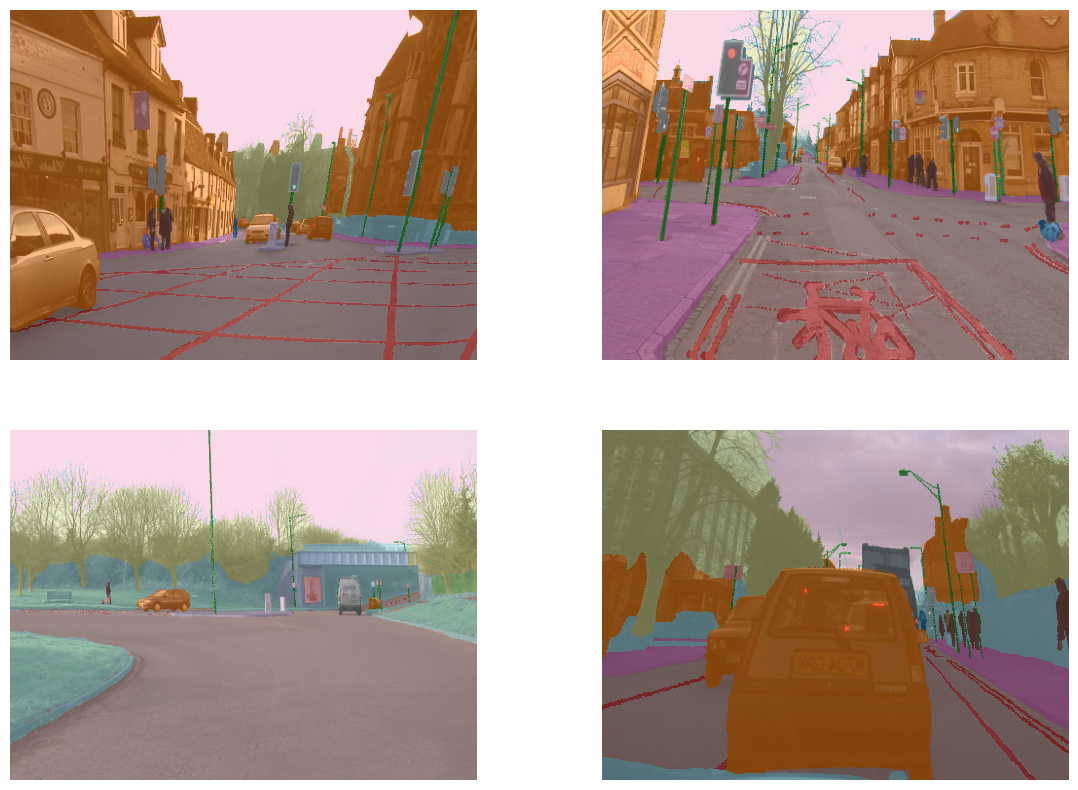

In [ ]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))

Lastly let's make our vocabulary a part of our `DataLoaders`, as our loss function needs to deal with the `Void` label

In [ ]:
dls.vocab = codes

Now we need a methodology for grabbing that particular code from our output of numbers. Let's make everything into a dictionary

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}

In [ ]:
name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'SUVPickupTruck': 22,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

Awesome! Let's make an accuracy function

In [ ]:
void_code = name2id['Void']
void_code 

30

For segmentation, we want to squeeze all the outputted values to have it as a matrix of digits for our segmentation mask. From there, we want to match their argmax to the target's mask for each pixel and take the average. `squeeze(1)` returns a tensor with a1-dimension removed if it is 1. `.argmax(dim=1)` returns `argmax` along axis 1. Axis 1 will correspond to the number of channels (or feature outputs).

In [ ]:
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

## The Dynamic Unet

Note: a dynamic Unet is a Unet model using PixelShuffle ICNR (initialization method for sub-pixel convolution) upsampling that can be built on top of any pretrained architecture. In practice, this means that we can use a model of our choice (`resnet34` below) as encoder, and we don't have to dtermine the architecture of the decoder, except for the options we want to set (see below).

![](http://tuatini.me/content/images/2017/09/u-net-architecture.png)

[Source](https://r.search.yahoo.com/_ylt=AwrExdqB0utfdJIAiU.jzbkF;_ylu=c2VjA2ZwLWF0dHJpYgRzbGsDcnVybA--/RV=2/RE=1609319169/RO=11/RU=https%3a%2f%2ftuatini.me%2fpractical-image-segmentation-with-unet%2f/RK=2/RS=ZXDe1xIW7NgnEcZwMcj9.YgKmG4-)

U-Net allows us to look at pixel-wise representations of our images through sizing it down and then blowing it back up into a high resolution image. The first part we call an "encoder" and the second a "decoder". The authors of the U-Net paper describe the arrows in the figure as "denotions of different operations"

We have a special `unet_learner`. Something new is we can pass in some model configurations where we can declare a few things to customize it with!

* Blur/blur final: avoid checkerboard artifacts
* Self attention: A self-attention layer
* y_range: Last activations go through a sigmoid for rescaling
* Last cross - Cross-connection with the direct model input
* Bottle - Bottlenck or not on that cross
* Activation function
* Norm type

Let's make a `unet_learner` that uses some of the new state of the art techniques. Specifically:

* Self-attention layers: `self_attention = True`
* Mish activation function: `act_cls = Mish`

U-Nets with self-attention gates are described in https://arxiv.org/abs/1804.03999. The *Mish activation function* (https://arxiv.org/abs/1908.08681) is an alternative to *ReLu*. It is a smooth, continuous, self regularized, non-monotonic activation function mathematically defined as
$$f(x)= x \, {\rm tanh} (\ln (1+e^x)).$$

Along with this we will use the `Ranger` as optimizer function.

In [ ]:
opt = ranger

**-cB-** `PixelShuffle` is an operation used in super-resolution models to implement efficient sub-pixel convolutions with a stride of 1/r. It rearranges elements in a tensor of shape `(∗, C × r^2, H, W)` to a tensor of shape `(∗, C, H × r, W × r)`(https://paperswithcode.com/method/pixelshuffle).

In the context of a U-Net architecture for image segmentation, `PixelShuffle` can be used in the upsampling path of the network to increase the spatial resolution of the feature maps. For example, Fastai's DynamicUnet allows construction of a U-Net using any pretrained CNN as backbone/encoder. A key module is `nn.PixelShuffle` which allows subpixel convolutions for upscaling in the U-Net Blocks (https://kbressem.github.io/faimed3d/models.unet.html).

In [ ]:
learn = unet_learner(dls, resnet34, metrics=acc_camvid, self_attention=True, act_cls=Mish, opt_func=opt)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 45.7MB/s]


In [ ]:
learn.summary()

DynamicUnet (Input shape: 8 x 3 x 360 x 480)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 180 x 240  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     8 x 64 x 90 x 120   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

If we do a `learn.summary` we can see this blow-up trend, and see that our model came in frozen. Let's find a learning rate

In [ ]:
if False:
  learn.lr_find()

In [ ]:
lr = 1e-3

With our new optimizer, we will also want to use a different fit function, called `fit_flat_cos`. 

**-cB-** `fit_flat_cos` is a training function in the fastai library that uses a flat cosine annealing schedule for the learning rate. It is similar to the `fit_one_cycle` function, which uses a 1cycle policy for the learning rate schedule, but `fit_flat_cos` is designed to be used with the Ranger optimizer.

A flat cosine annealing schedule starts with a constant learning rate for a certain percentage of the training (`pct_start`), then decreases the learning rate from its initial value to a final value (`div_final`) following a cosine annealing schedule for the remaining percentage of the training. This type of schedule can help improve the convergence and generalization performance of the model.

The `fit_flat_cos` function takes as input a learner object, the number of epochs to train for (`n_epoch`), and several optional arguments such as the initial learning rate (`lr`), the final learning rate (`div_final`), the percentage of training to use for the flat part of the schedule (`pct_start`), weight decay (`wd`), and callbacks (`cbs`). You can use these arguments to customize the training process and fine-tune your model.

In [ ]:
if False: 
  learn.fit_flat_cos(1, slice(lr)) # with just one epoch, results are really bad (for the classroom)
else: 
  learn.fit_flat_cos(10, slice(lr)) # the thing to do, but it takes longer

epoch,train_loss,valid_loss,acc_camvid,time
0,1.176217,0.599632,0.846561,01:34
1,0.728614,0.477019,0.869262,01:39
2,0.561289,0.385345,0.890826,01:39
3,0.476125,0.337271,0.902089,01:39
4,0.434707,0.384904,0.893622,01:39
5,0.408116,0.319190,0.909748,01:39
6,0.376090,0.318265,0.911887,01:39
7,0.350156,0.303403,0.910828,01:39
8,0.305228,0.287817,0.913636,01:39
9,0.270194,0.273444,0.919121,01:39


In [ ]:
learn.save('stage-1')
learn.load('stage-1');

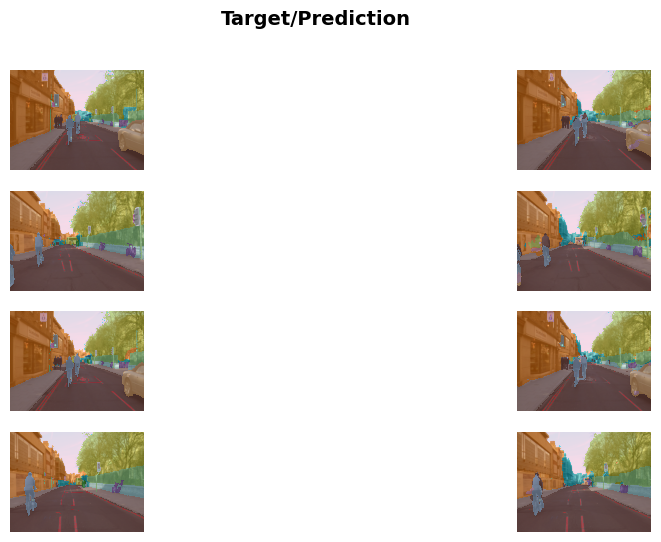

In [ ]:
learn.show_results(max_n=4, figsize=(12,6))

Let's unfreeze the model and decrease our learning rate by 4 (Rule of thumb)

In [ ]:
lrs = slice(lr/400, lr/4)

In [ ]:
lr, lrs

(0.001, slice(2.5e-06, 0.00025, None))

**-cB-** In the `fastai` library, the `unfreeze` method is used to "unfreeze" a model, which means making all of its layers trainable. When you first create a model using a pre-trained neural network, the weights of the pre-trained layers are usually "frozen", meaning that they are not updated during training. This allows you to fine-tune the later layers of the model without changing the pre-trained weights.

The `unfreeze` method sets all layers of the model to be trainable, so that their weights can be updated during training. This can be useful when you want to fine-tune the entire model, not just the later layers. Here's an example of how you could use the `unfreeze` method:

```python
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1) # fine-tune only the later layers

learn.unfreeze() # unfreeze all layers
learn.fit_one_cycle(1) # fine-tune all layers
```

In the example above, we create a `cnn_learner` using a pre-trained `resnet34` model and fine-tune it for one epoch using the `fine_tune` method. By default, only the later layers of the model are trained during fine-tuning. We then call the `unfreeze` method to make all layers of the model trainable and fine-tune all layers for one more epoch using the `fit_one_cycle` method.

In [ ]:
learn.unfreeze()

And train for a bit more

In [ ]:
learn.fit_flat_cos(12, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.257861,0.279348,0.918203,00:22
1,0.252161,0.259110,0.924652,00:22
2,0.246559,0.265292,0.922612,00:22
3,0.238134,0.269632,0.923062,00:22
4,0.228254,0.286329,0.919512,00:22
5,0.220706,0.259227,0.925018,00:22
6,0.218496,0.277637,0.920875,00:22
7,0.215364,0.280609,0.920992,00:22
8,0.208050,0.280713,0.921068,00:22
9,0.205963,0.272539,0.922798,00:22


Now let's save that model away

In [ ]:
learn.save('model_1')

Path('models/model_1.pth')

And look at a few results

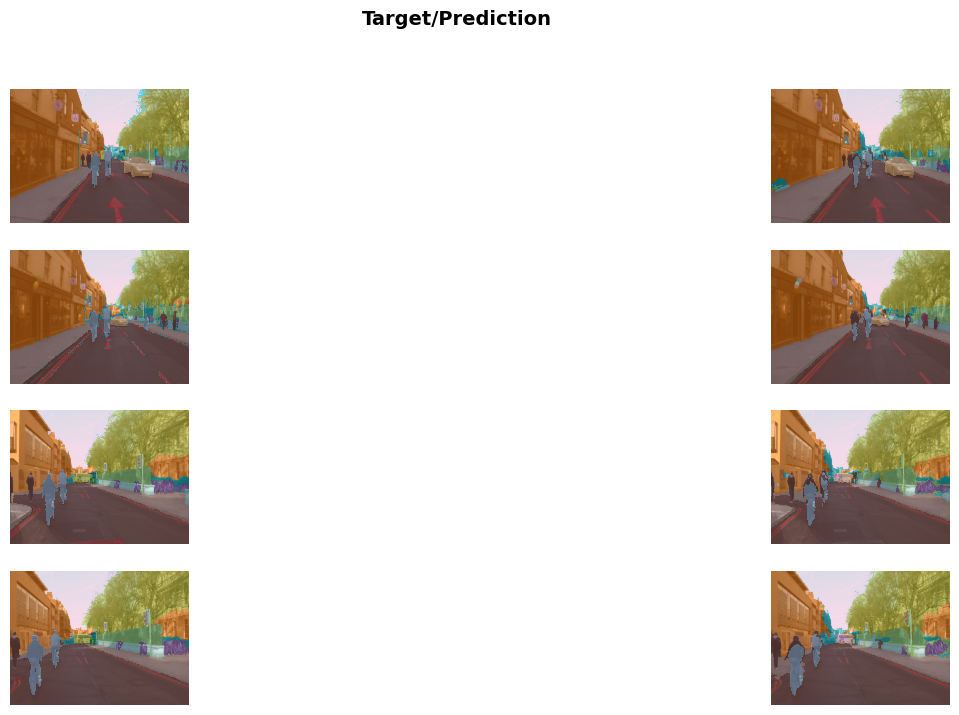

In [ ]:
learn.show_results(max_n=4, figsize=(18,8))

## Inference

Let's take a look at how to do inference with `test_dl`.

**-cB-** `test_dl` is a method in the `fastai` library that allows you to create a `DataLoader` for a test set (https://muellerzr.github.io/fastblog/2020/08/10/testdl.html). This can be useful when you want to make predictions on new data that was not part of the training or validation sets. You can pass your test data to the `test_dl` method and it will apply the same data processing pipeline that was used for the training data, so that your test data is in the correct format for making predictions with your trained model (https://docs.fast.ai/data.load.html).

Here's an example of how you could use `test_dl` to create a `DataLoader` for a test set and make predictions on it:

```python
# assuming you have a `DataLoaders` object named `dls`
test_data = ... # your test data
dl = dls.test_dl(test_data) # create a test DataLoader
preds, _ = learn.get_preds(dl=dl) # make predictions
```

In [ ]:
dl = learn.dls.test_dl(fnames[:5])

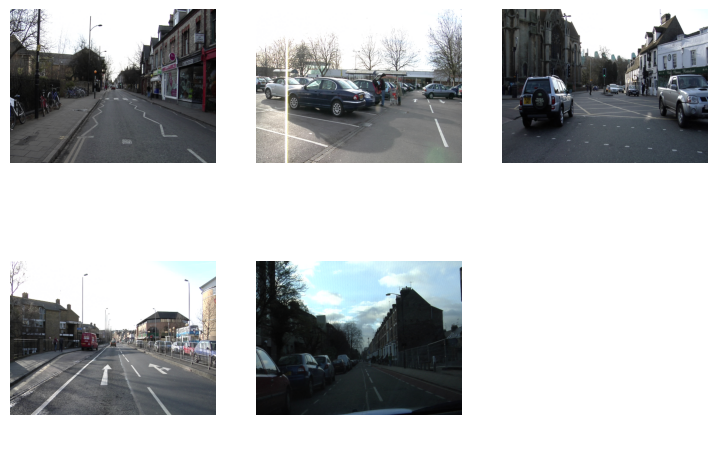

In [ ]:
dl.show_batch()

Let's do the first five pictures

In [ ]:
preds = learn.get_preds(dl=dl)

In [ ]:
preds[0].shape

torch.Size([5, 32, 360, 480])

Alright so we have a 5x32x360x480

In [ ]:
len(codes)

32

What does this mean? We had five images, so each one is one of our five images in our batch. Let's look at the first

In [ ]:
pred_1 = preds[0][0]

In [ ]:
pred_1.shape

torch.Size([32, 360, 480])

Now let's take the argmax of our values

In [ ]:
pred_arx = pred_1.argmax(dim=0)

And look at it

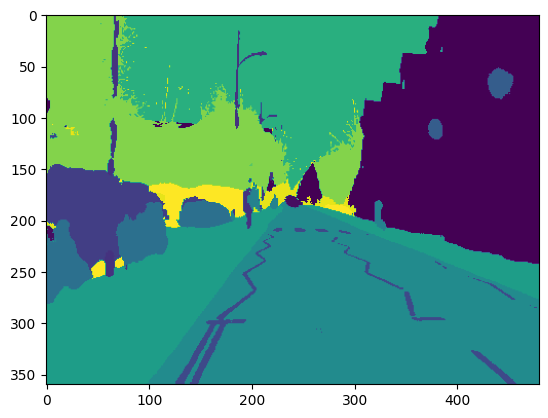

In [ ]:
plt.imshow(pred_arx)

What do we do from here? We need to save it away. We can do this one of two ways, as a numpy array to image, and as a tensor (to say use later rawly)

In [ ]:
pred_arx = pred_arx.numpy()

In [ ]:
rescaled = (255.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)

In [ ]:
im = Image.fromarray(rescaled)

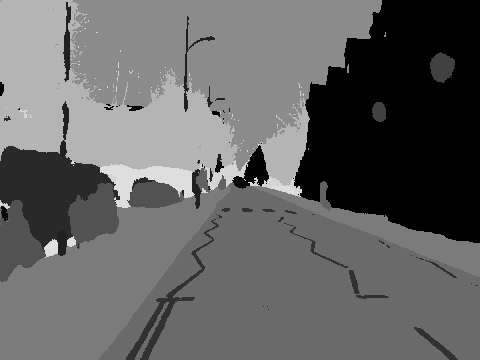

In [ ]:
im

In [ ]:
im.save('test.png')

Let's make a function to do so for our files

In [ ]:
for i, pred in enumerate(preds[0]):
  pred_arg = pred.argmax(dim=0).numpy()
  rescaled = (255.0 / pred_arg.max() * (pred_arg - pred_arg.min())).astype(np.uint8)
  im = Image.fromarray(rescaled)
  im.save(f'Image_{i}.png')

Now let's save away the raw:

In [ ]:
torch.save(preds[0][0], 'Image_1.pt')

In [ ]:
pred_1 = torch.load('Image_1.pt')

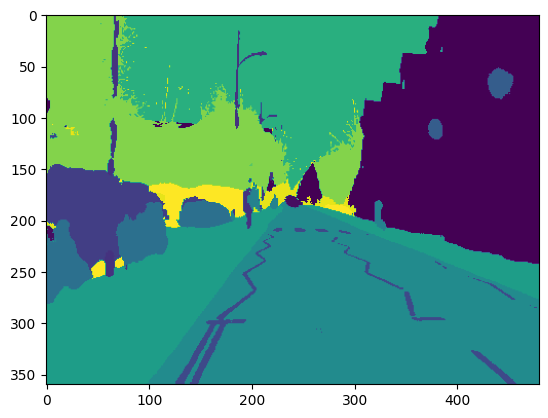

In [ ]:
plt.imshow(pred_1.argmax(dim=0))